# Texture Analysis Notebook for PNG CT Images

This notebook provides an easy-to-use tool for performing texture analysis on PNG medical images (assumed to be CT images).
It computes texture features using the Gray-Level Co-occurrence Matrix (GLCM).

**Features:**

- **Texture Features:**
  Computes the following GLCM-based features:
  - **Contrast:** Quantifies local intensity variations.
  - **Correlation:** Measures the linear dependency between neighboring pixels.
  - **Energy:** Indicates textural uniformity.
  - **Homogeneity:** Reflects the closeness of the distribution of elements in the GLCM to its diagonal.

- **Basic Statistics:**
  Calculates the mean, standard deviation, and median of the image intensities.

- **Black Frame Detection:**
  Automatically skips images that are completely black (i.e. maximum pixel value is 0).

- **Output:**
  Saves the analysis results in a CSV file and displays the images along with the computed metrics.

**Instructions:**

1. Adjust the `image_directory` variable (the folder containing your PNG images).
2. Run the notebook cells in order.
3. Converted images will be stored in a subfolder named `CT_converted`.
4. The texture analysis results will be saved to `texture_analysis_results.csv`.

---

## Explanation of Texture Analysis Methods

The notebook computes several texture features based on the Gray-Level Co-occurrence Matrix (GLCM). Each metric provides insight into the spatial distribution and relationship of pixel intensities within the image:

- **Contrast:**
  Measures the local variations in intensity. High contrast may indicate heterogeneous tissue.

- **Correlation:**
  Assesses the linear dependency between pixel intensities. Higher correlation can suggest more uniform textures.

- **Energy:**
  Also known as Angular Second Moment, it reflects textural uniformity. Higher energy implies smoother textures.

- **Homogeneity:**
  Indicates the closeness of the distribution of elements in the GLCM to the diagonal, reflecting texture smoothness.

- **Basic Statistics (Mean, Standard Deviation, Median):**
  These provide additional details about the intensity distribution, which can be useful for further clinical insights.

---

Proceed with the code cell below to run the texture analysis.


In [ ]:
!pip install numpy pandas matplotlib SimpleITK scikit-image jupyter

## Import Packages

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.util import img_as_ubyte

# Enable inline plotting in Jupyter
%matplotlib inline

## CT Processing Functions

In [2]:
def normalize_to_unit_range(image_array):
    """
    Normalize a floating point image so that its values span [-1, 1].
    If the image is constant, return an array of zeros.
    """
    min_val = image_array.min()
    max_val = image_array.max()
    if max_val - min_val == 0:
        return np.zeros_like(image_array, dtype=np.float32)
    # Scale image to [0, 1] then to [-1, 1]
    normalized = 2 * (image_array - min_val) / (max_val - min_val) - 1
    return normalized.astype(np.float32)

def ensure_image(input_path, output_path):
    """
    Reads a TIFF image and ensures it has a supported pixel type.
    First, attempts to read using SimpleITK. If that fails (e.g. due to 64-bit samples)
    or if the file extension is .tif, the function falls back to using tifffile.
    For TIFF images loaded via tifffile, if the image is multichannel (RGB or RGBA),
    it is converted to grayscale and scaled to uint8. If the image dtype is not uint8,
    it is normalized to the 0-255 range.
    Finally, the image is converted (if needed) to a supported pixel type (sitkUInt8,
    sitkInt8, sitkUInt16, sitkInt16, or sitkFloat32) and saved.
    """
    try:
        # Try reading with SimpleITK
        image = sitk.ReadImage(input_path)
    except Exception as e:
        image = None

    # If reading failed or if the file extension is .tif, try using tifffile
    if image is None or input_path.lower().endswith('.tif'):
        try:
            import tifffile
            from skimage.color import rgb2gray
            import cv2
            image_array = tifffile.imread(input_path)
            # If multichannel, convert to grayscale
            if image_array.ndim == 3:
                if image_array.shape[-1] in [3, 4]:
                    image_array = rgb2gray(image_array)
                    image_array = (image_array * 255).astype(np.uint8)
                else:
                    image_array = image_array[:, :, 0]
            # Normalize image to uint8 if necessary
            if image_array.dtype != np.uint8:
                image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            image = sitk.GetImageFromArray(image_array)
            print(f"Successfully read {input_path} with tifffile.")
        except Exception as e2:
            return None

    # For floating point images, if the values are not in [-1, 1], normalize them.
    image_array = sitk.GetArrayFromImage(image)
    if np.issubdtype(image_array.dtype, np.floating):
        if image_array.min() < -1 or image_array.max() > 1:
            image_array = normalize_to_unit_range(image_array)
            image = sitk.GetImageFromArray(image_array)
            try:
                original = sitk.ReadImage(input_path)
                image.CopyInformation(original)
            except Exception:
                pass

    # Allowed pixel types for TIFF writing.
    allowed_types = [sitk.sitkUInt8, sitk.sitkInt8, sitk.sitkUInt16, sitk.sitkInt16, sitk.sitkFloat32]
    if image.GetPixelID() not in allowed_types:
        image = sitk.Cast(image, sitk.sitkFloat32)

    try:
        sitk.WriteImage(image, output_path)
        print(f"Saved converted image to {output_path}")
    except Exception as e:
        return None

    return output_path

## Image Stack Analysis Function

In [3]:
def analyze_texture(image_path):
    """
    Analyzes the texture of a CT or MRI image.
    The image is read with SimpleITK, converted to 8-bit (using img_as_ubyte),
    and then used to compute the Gray-Level Co-occurrence Matrix (GLCM) and
    derived texture features.
    Black frames (i.e. images with a maximum pixel value of 0) are skipped.
    """
    try:
        image = sitk.ReadImage(image_path)
        image_array = sitk.GetArrayFromImage(image)
        # Skip completely black images.
        if np.max(image_array) == 0:
            print(f"Skipping image {image_path} because it is a black frame.")
            return None

        image_array = img_as_ubyte(image_array)
        distances = [5]
        angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
        glcm = graycomatrix(image_array, distances=distances, angles=angles,
                             symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        mean_val = np.mean(image_array)
        std_val = np.std(image_array)
        median_val = np.median(image_array)
        return {
            'contrast': contrast,
            'correlation': correlation,
            'energy': energy,
            'homogeneity': homogeneity,
            'mean': mean_val,
            'std': std_val,
            'median': median_val
        }
    except Exception as e:
        return None

def analyze_image_stack(image_directory, output_csv, converted_dir=None):
    """
    Analyzes a stack of TIFF images in a directory and saves the results to a CSV file.
    Each file is converted (if needed) using the CT/MRI processing pipeline and then analyzed.
    Black frame images are skipped.
    """
    all_features = {}
    # Filter for TIFF files.
    image_files = [f for f in os.listdir(image_directory) if f.lower().endswith('.tif')]

    # Sort files based on a numerical part of the filename.
    def extract_number(filename):
        match = re.search(r'_(\d{4})\.tif$', filename)
        return int(match.group(1)) if match else 0

    image_files.sort(key=extract_number)

    # If no converted directory is provided, make one inside image_directory.
    if converted_dir is None:
        converted_dir = os.path.join(image_directory, "MRI_converted")
    if not os.path.exists(converted_dir):
        os.makedirs(converted_dir)
    for image_file in image_files:
        original_path = os.path.join(image_directory, image_file)
        converted_path = os.path.join(converted_dir, image_file)
        ct_path = ensure_image(original_path, converted_path)
        if ct_path is None:
            continue
        features = analyze_texture(ct_path)
        if features is not None:
            all_features[image_file] = features

    # Save the results to CSV.
    df = pd.DataFrame.from_dict(all_features, orient='index')
    df.to_csv(output_csv, index=True)
    print(f"Texture analysis results saved to {output_csv}")
    return all_features

## Show Images With Analysis

In [4]:
def show_images_with_analysis(converted_dir, all_features):
    """
    Displays CT images (from the converted folder) along with their texture analysis.
    """
    for image_file, features in all_features.items():
        image_path = os.path.join(converted_dir, image_file)
        try:
            image = sitk.ReadImage(image_path)
            image_array = sitk.GetArrayFromImage(image)
        except Exception as e:
            print(f"Error reading CT image {image_path} for display: {e}")
            continue
        plt.figure()
        plt.imshow(image_array, cmap='gray')
        plt.title(f"{image_file}\nContrast: {features['contrast']:.2f}, "
                  f"Correlation: {features['correlation']:.2f}, Energy: {features['energy']:.2f}, "
                  f"Homogeneity: {features['homogeneity']:.2f}")
        plt.axis('off')
        plt.show()

## Main Cell

Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0000.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0000.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0000.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0001.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0001.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0001.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0002.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0002.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0002.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0003.tif with tifffile.
Saved converted

Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0065.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0065.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0065.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0066.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0066.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0066.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0067.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0067.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0067.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0068.tif with tifffile.
Saved converted

Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0134.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0134.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0135.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0135.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0135.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0136.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0136.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0136.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0137.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0137.tif
Skippin

Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0168.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0168.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0169.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0169.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0170.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0170.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0171.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0171.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0172.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0172.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0173.tif with ti

Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0217.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0217.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0218.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0218.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0219.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0219.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0220.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0220.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0221.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0221.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0222.tif with ti

Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0268.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0268.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0269.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0269.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0270.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0270.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0271.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0271.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0272.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0272.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0273.tif with ti

Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0315.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0315.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0316.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0316.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0317.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0317.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0318.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0318.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0319.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0319.tif
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0320.tif with ti

Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0392.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0392.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0392.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0393.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0393.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0393.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0394.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0394.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0394.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0395.tif with tifffile.
Saved converted

Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0445.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0445.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0446.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0446.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0446.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0447.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0447.tif
Skipping image /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0447.tif because it is a black frame.
Successfully read /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_0448.tif with tifffile.
Saved converted image to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/MRI_3_0448.tif
Skippin

Texture analysis results saved to /Users/colehanan/Desktop/group_10/MRI_3/MRI_3_converted/texture_analysis_results.csv


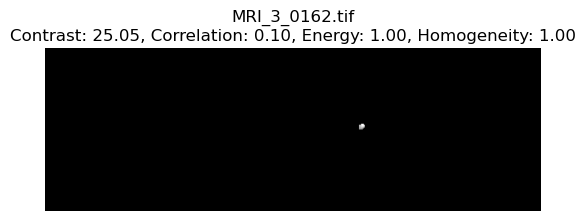

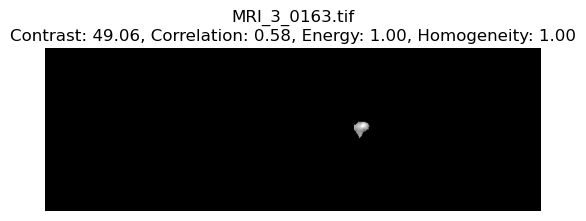

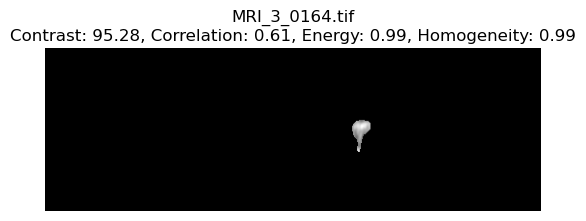

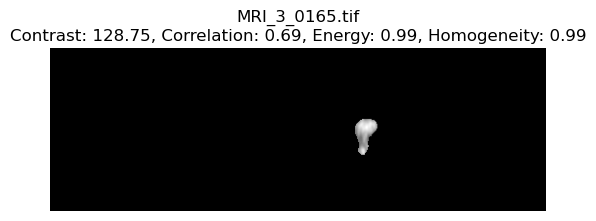

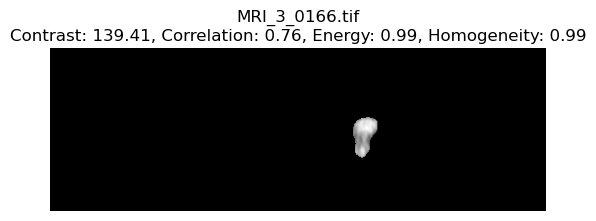

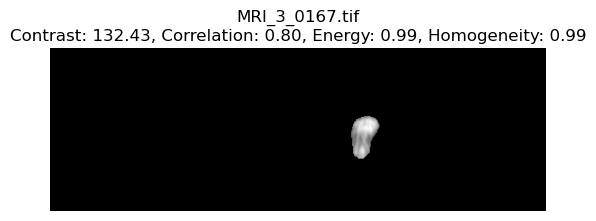

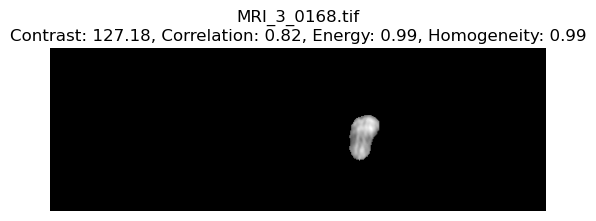

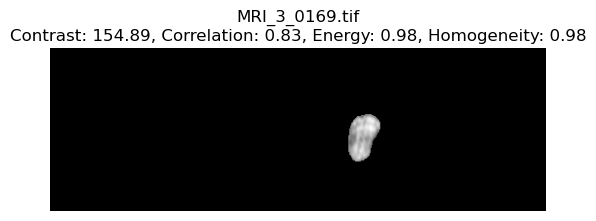

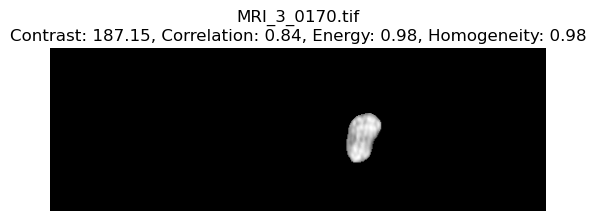

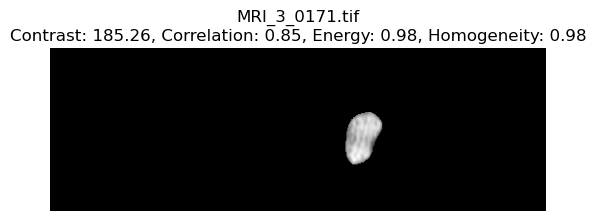

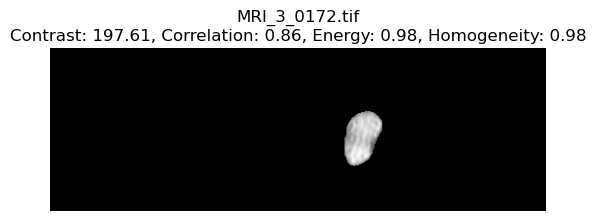

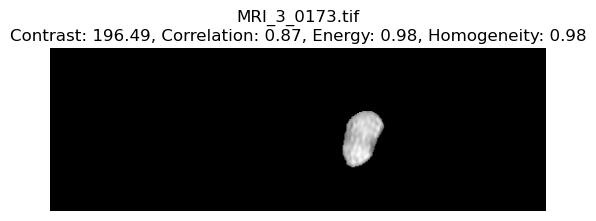

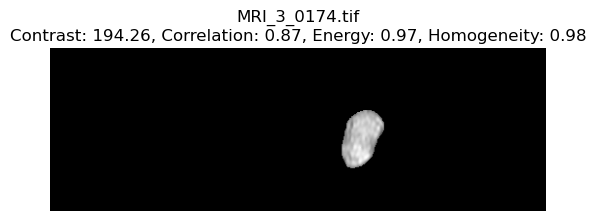

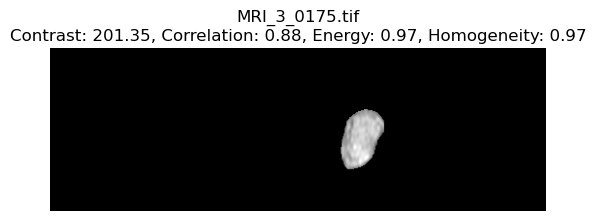

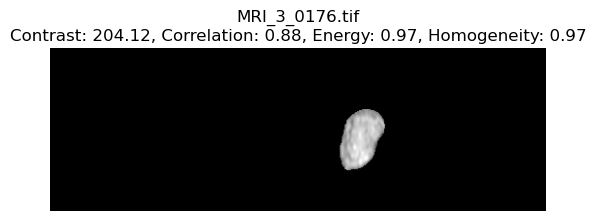

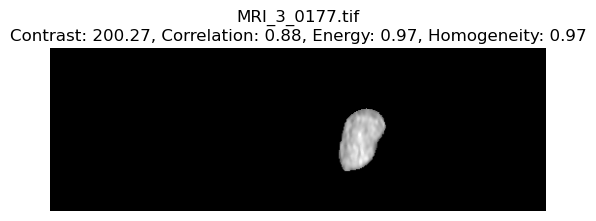

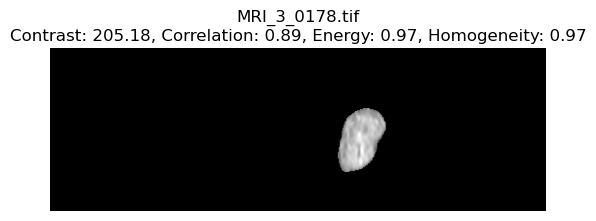

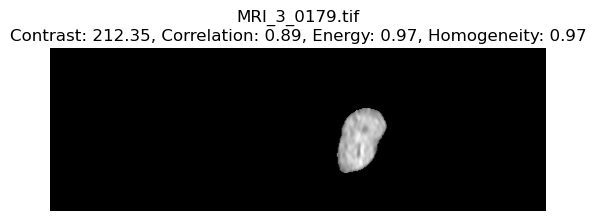

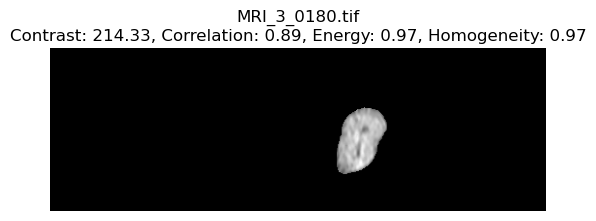

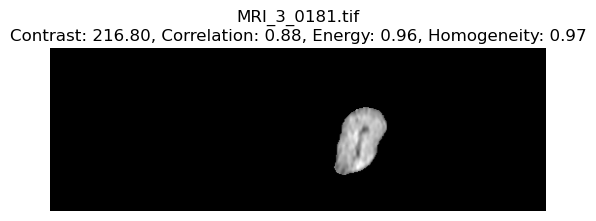

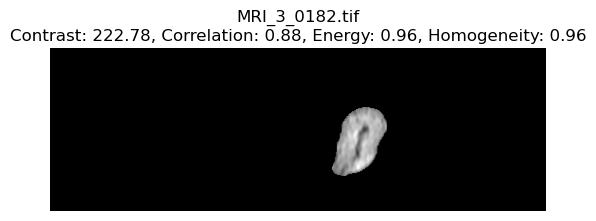

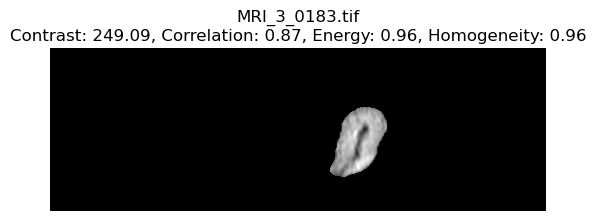

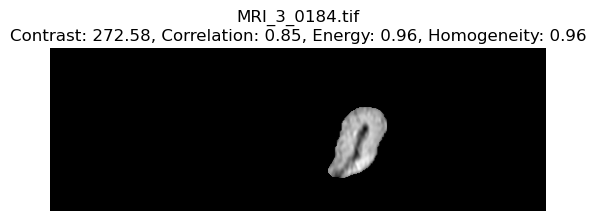

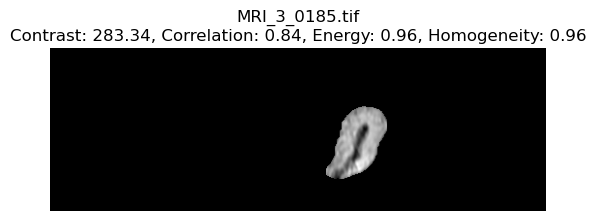

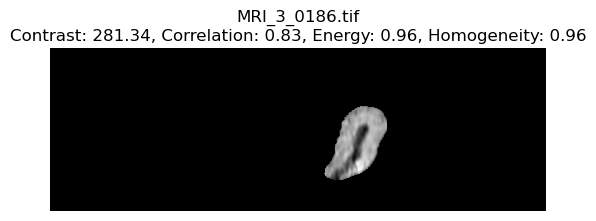

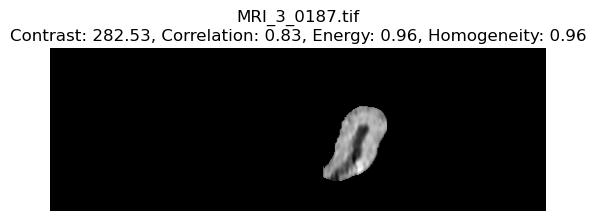

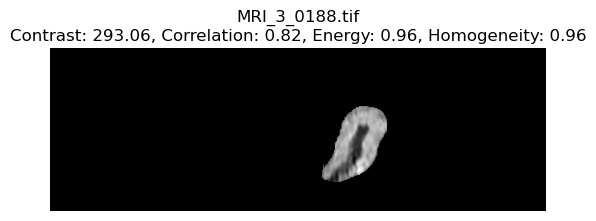

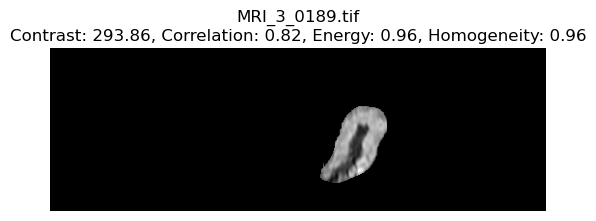

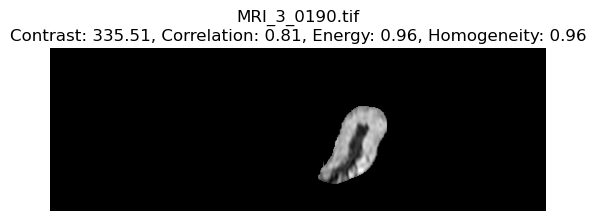

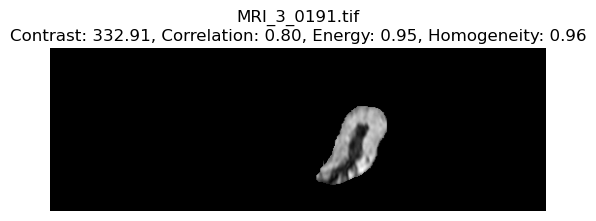

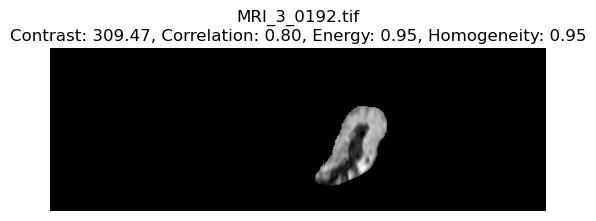

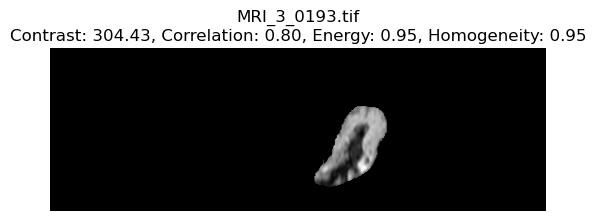

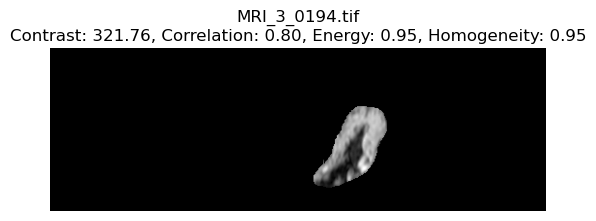

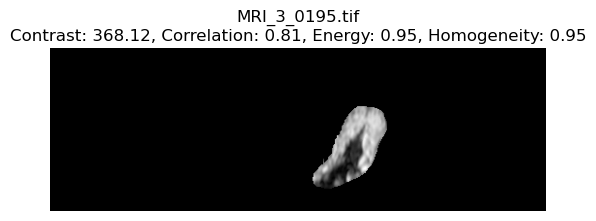

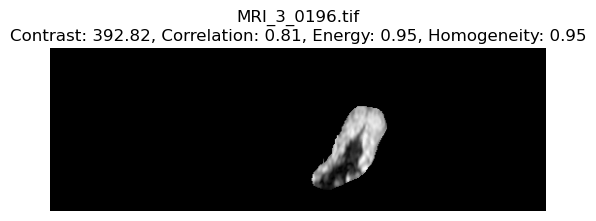

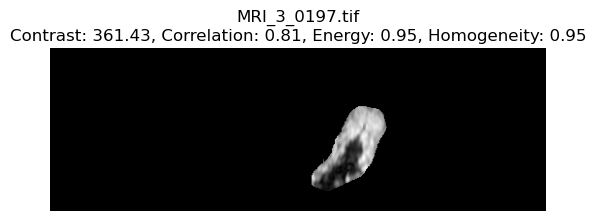

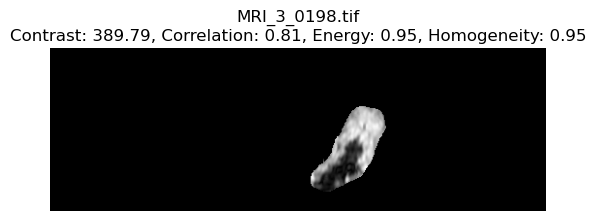

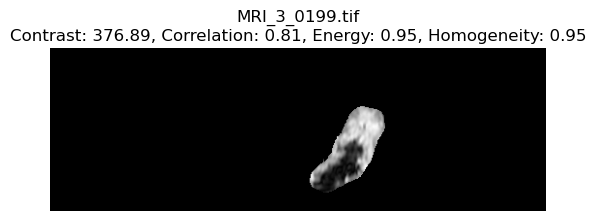

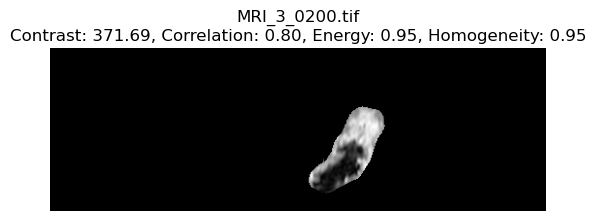

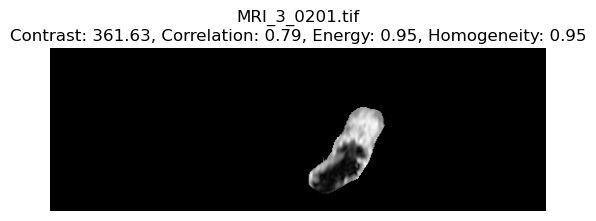

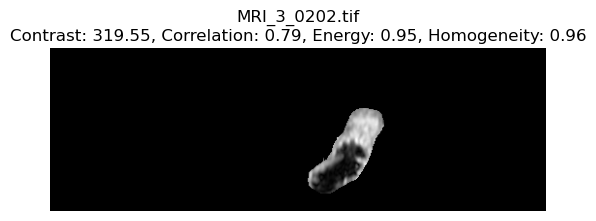

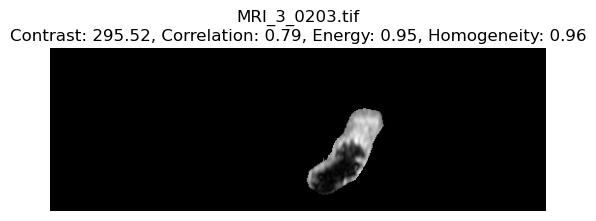

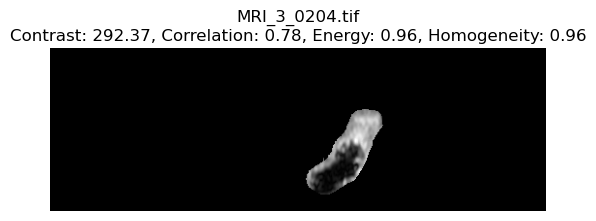

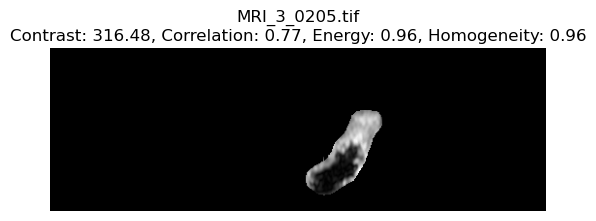

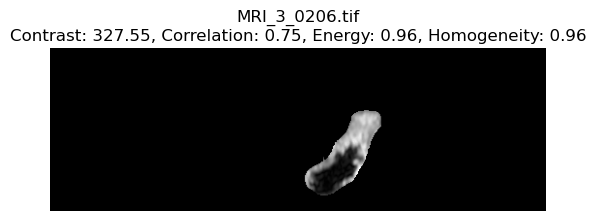

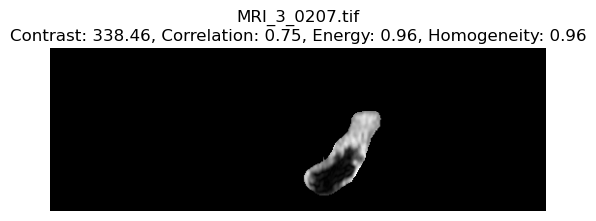

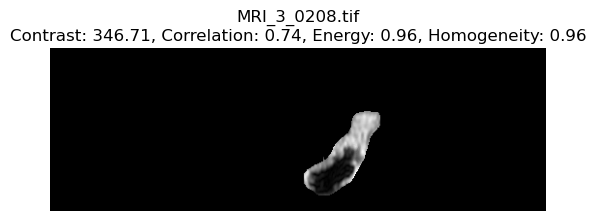

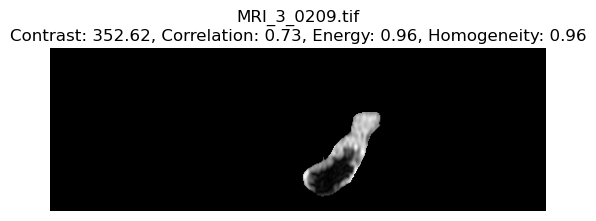

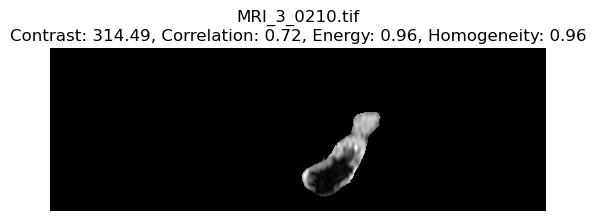

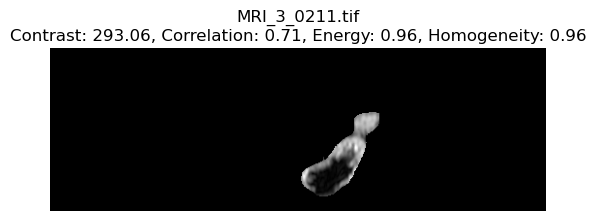

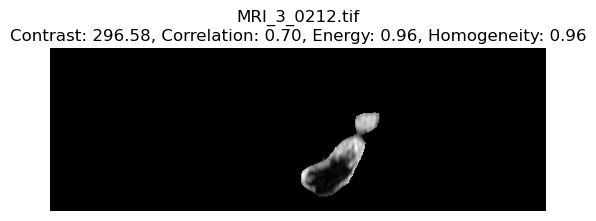

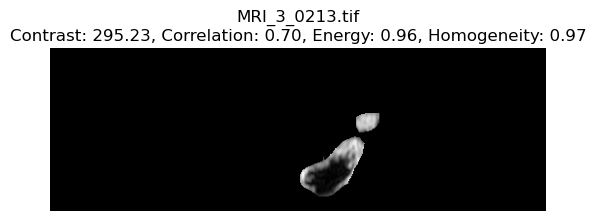

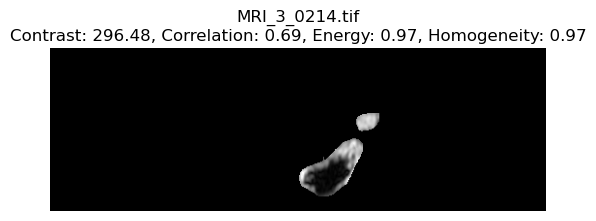

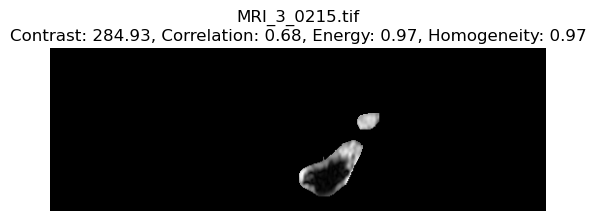

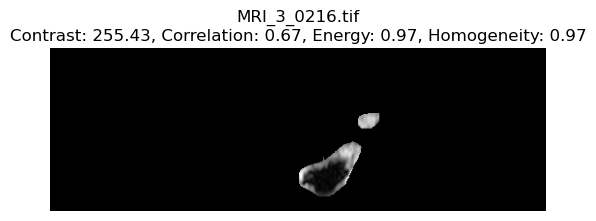

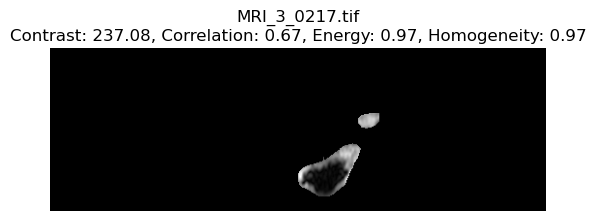

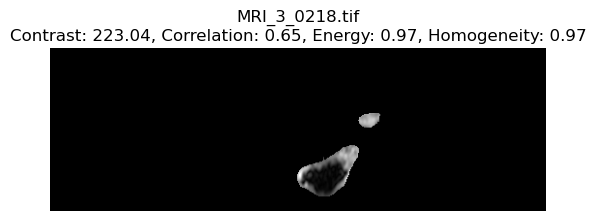

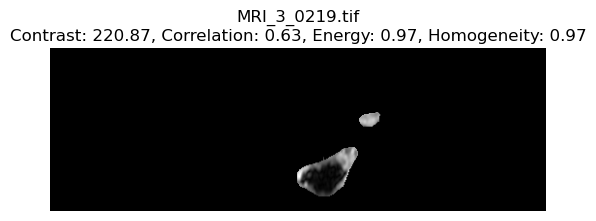

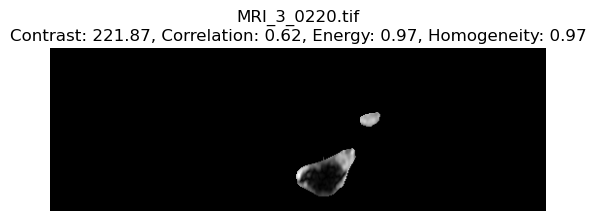

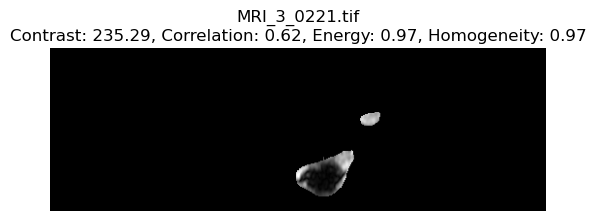

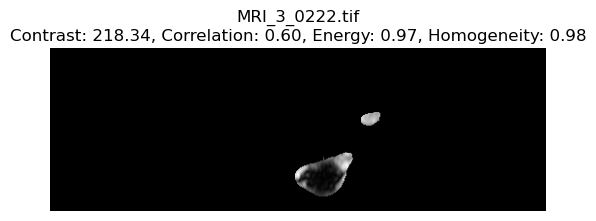

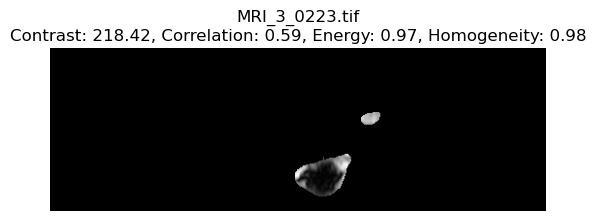

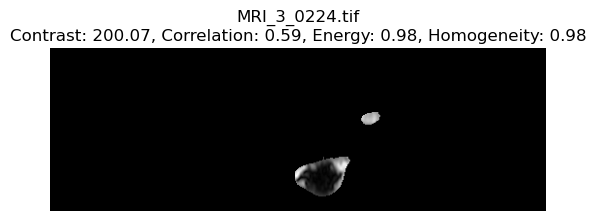

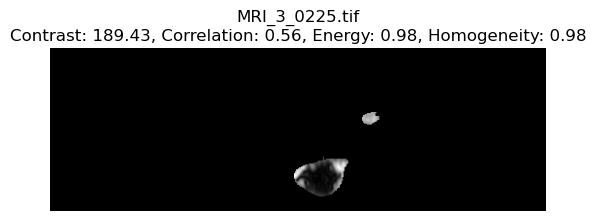

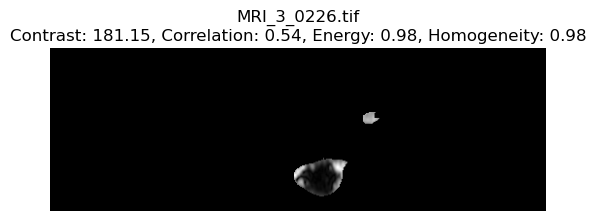

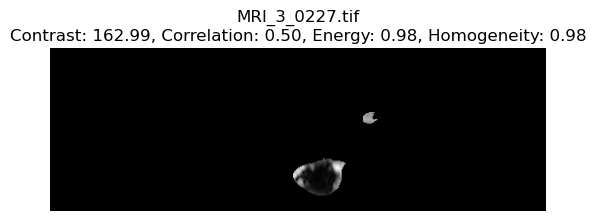

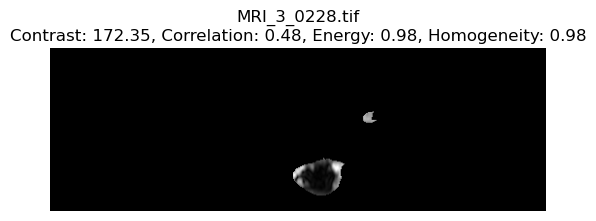

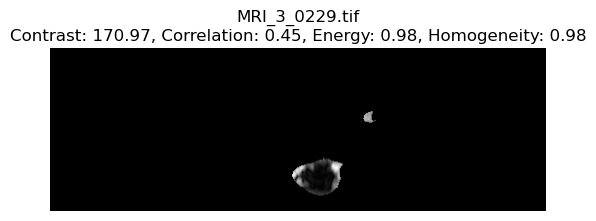

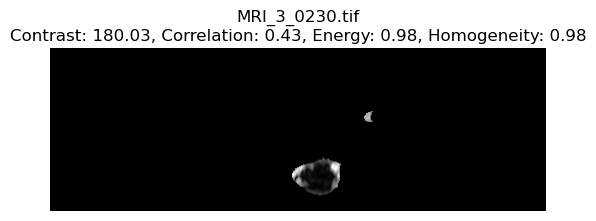

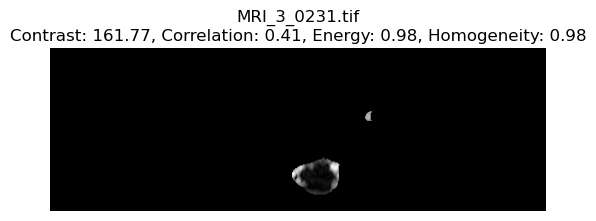

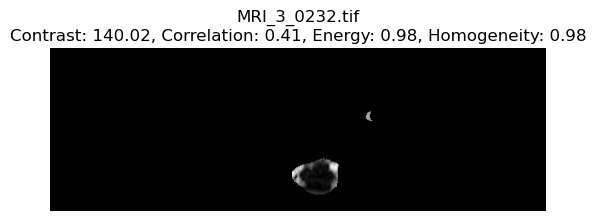

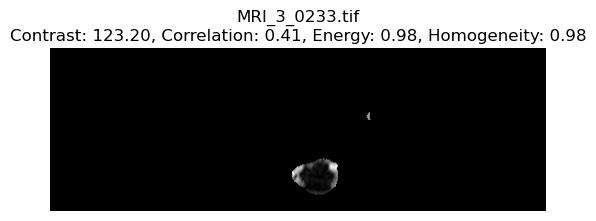

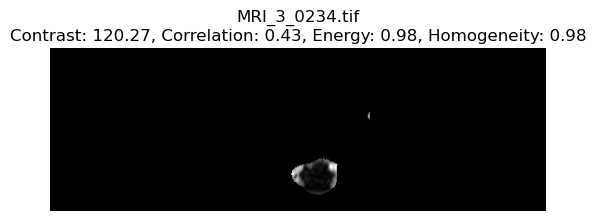

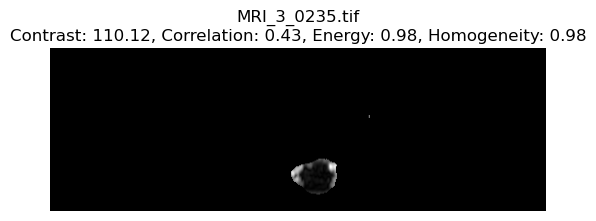

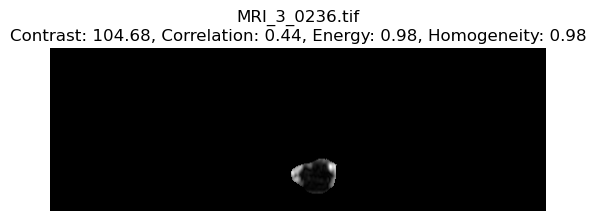

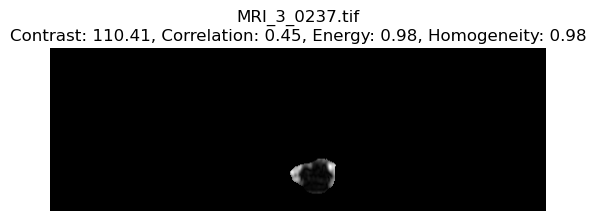

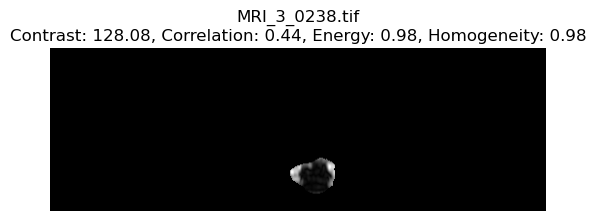

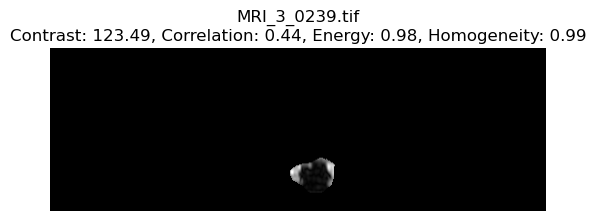

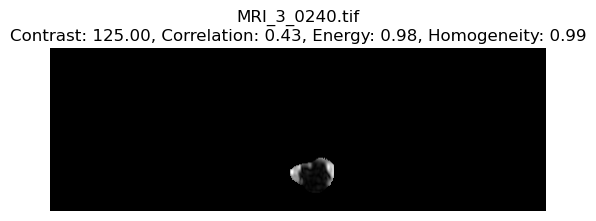

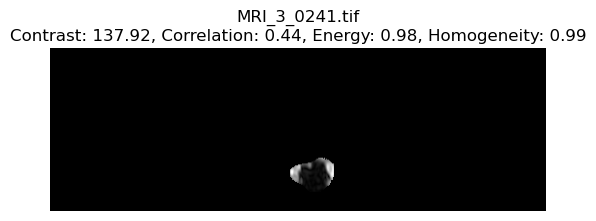

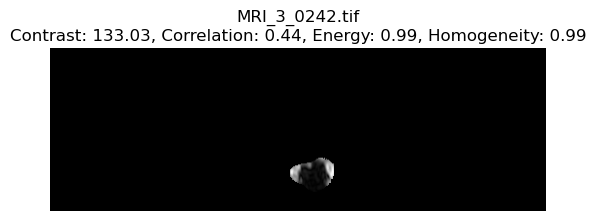

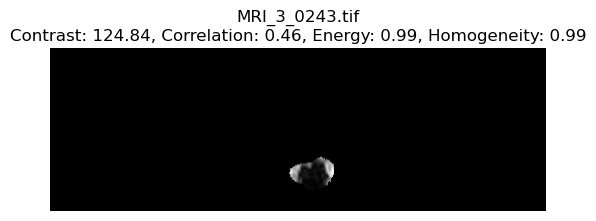

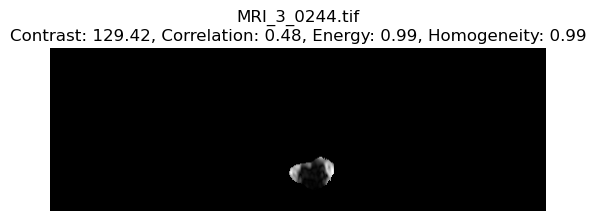

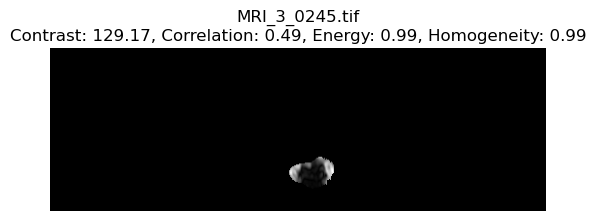

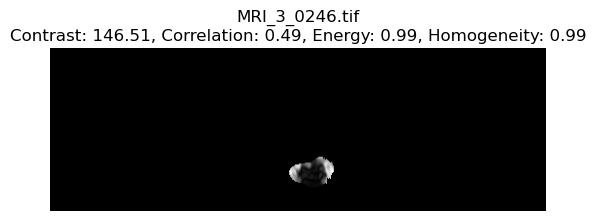

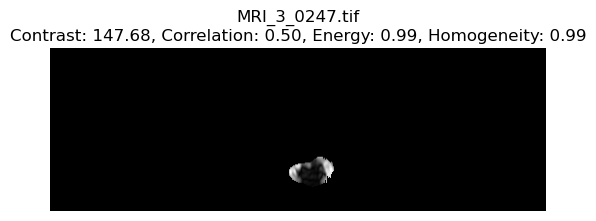

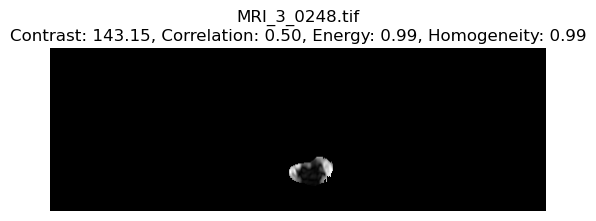

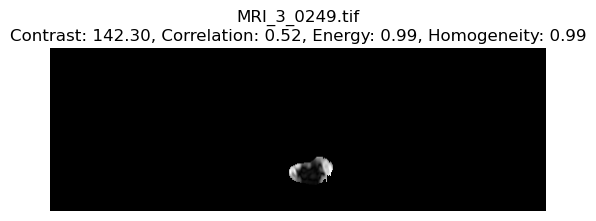

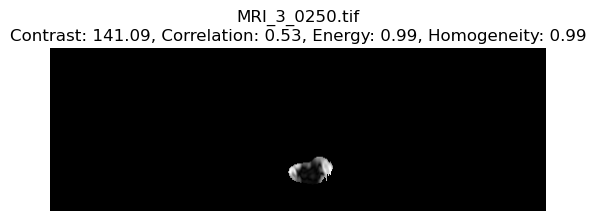

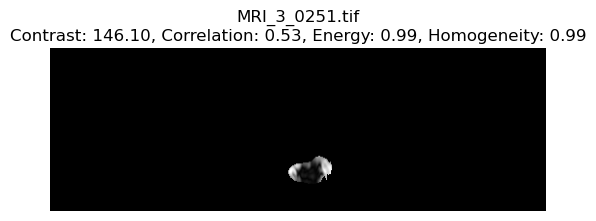

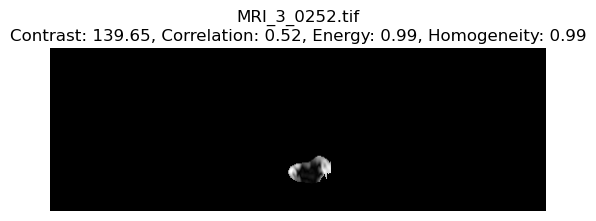

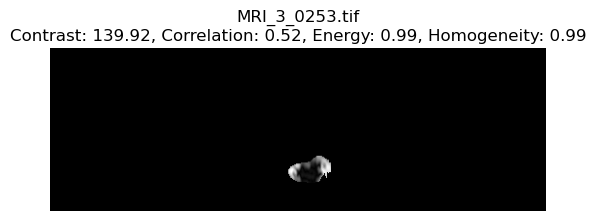

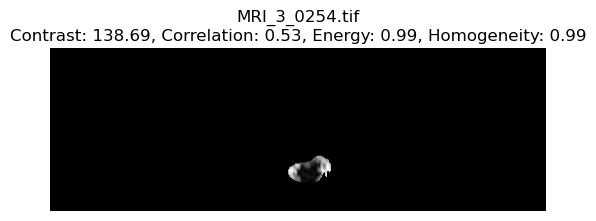

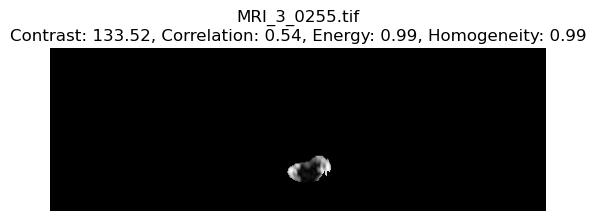

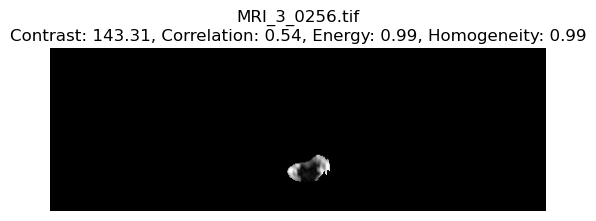

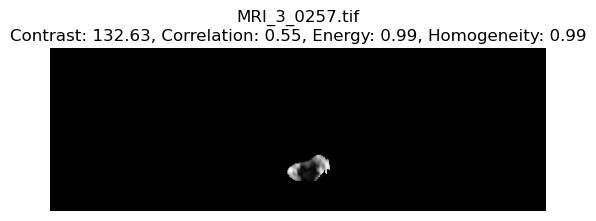

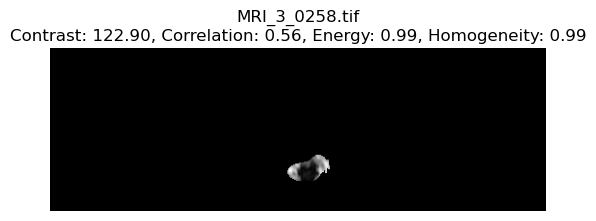

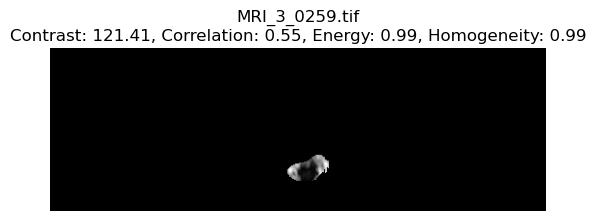

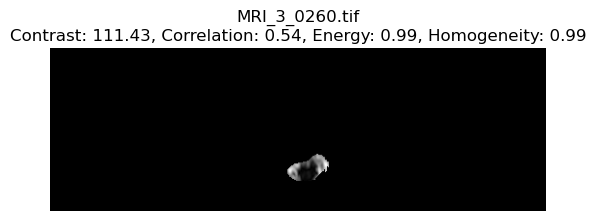

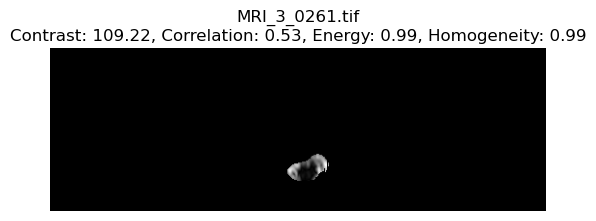

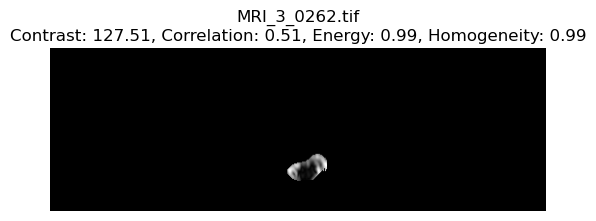

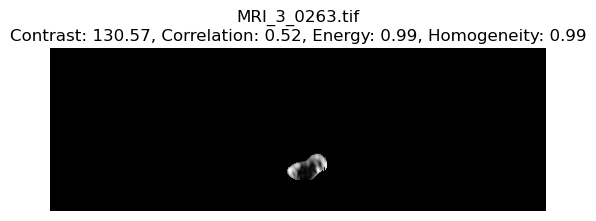

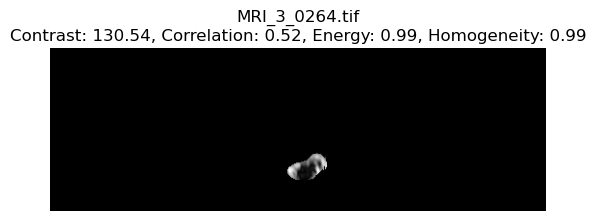

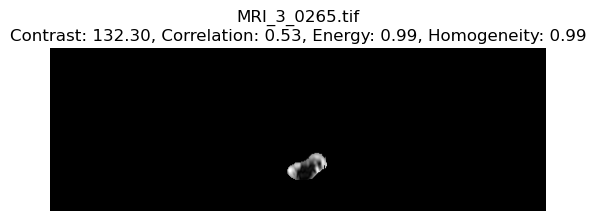

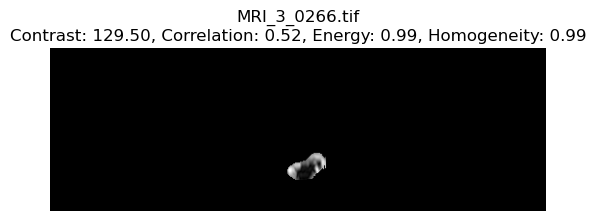

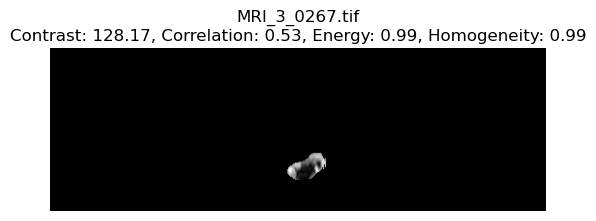

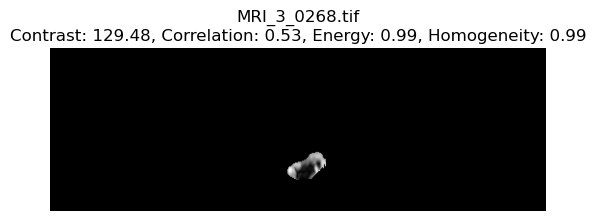

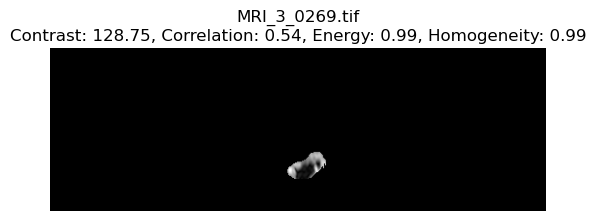

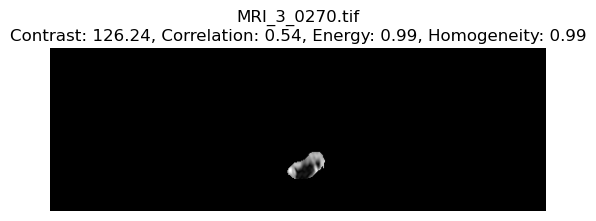

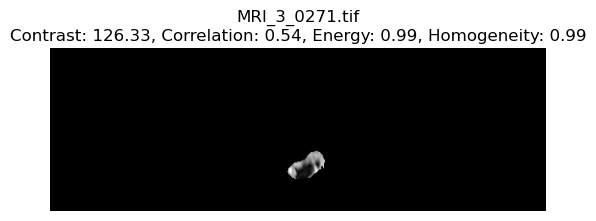

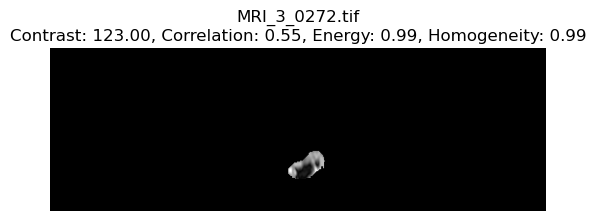

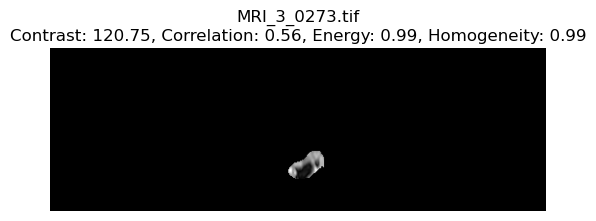

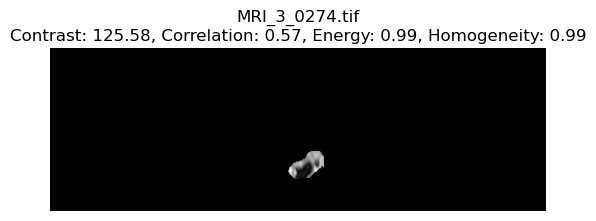

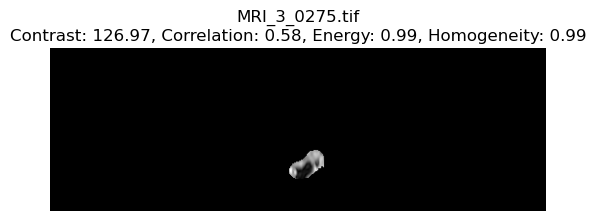

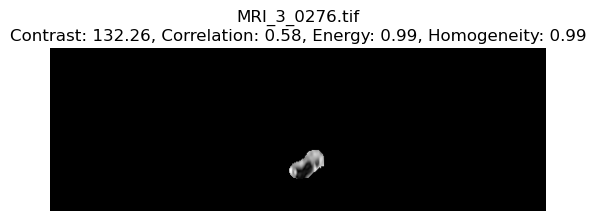

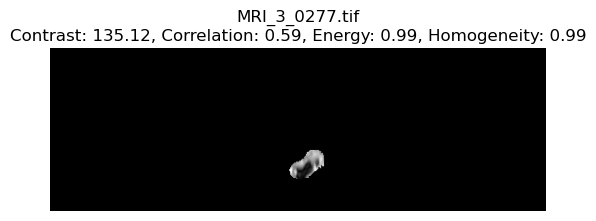

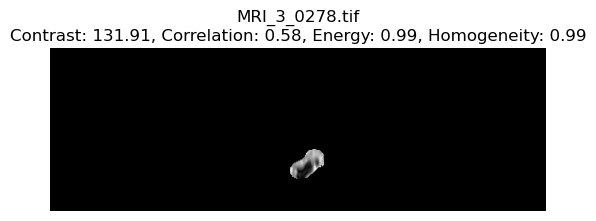

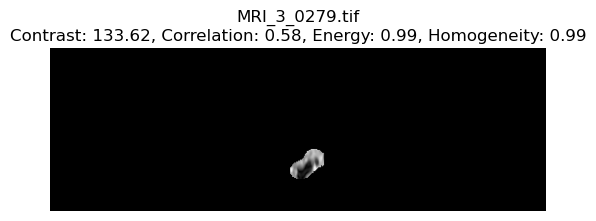

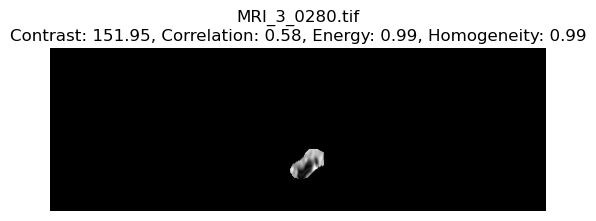

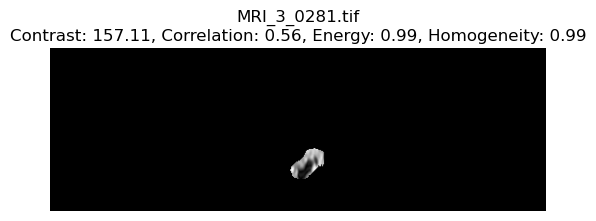

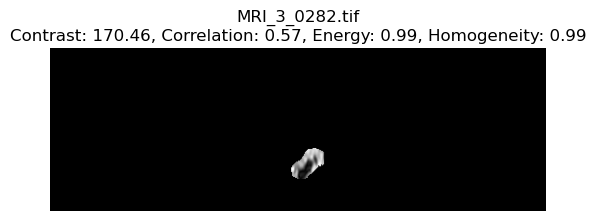

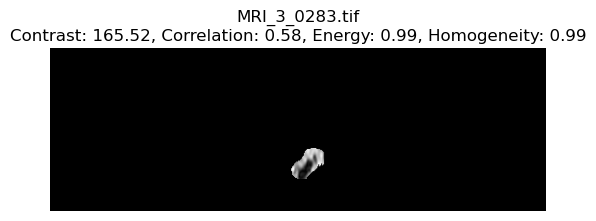

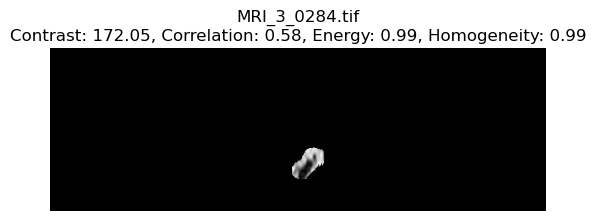

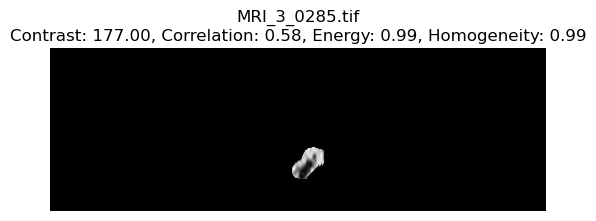

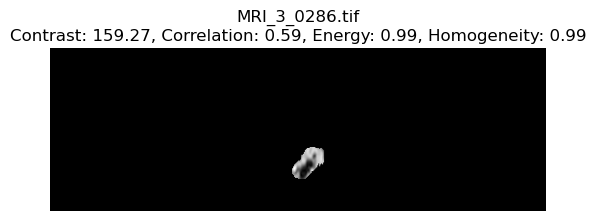

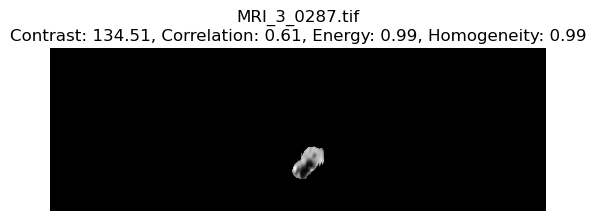

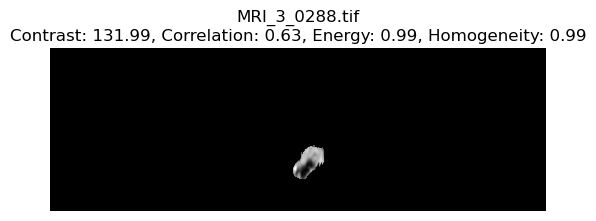

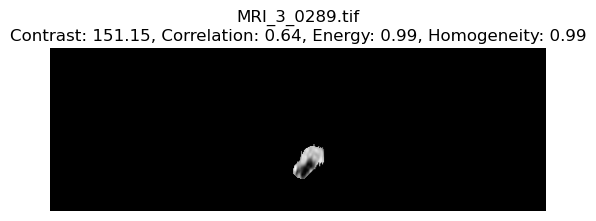

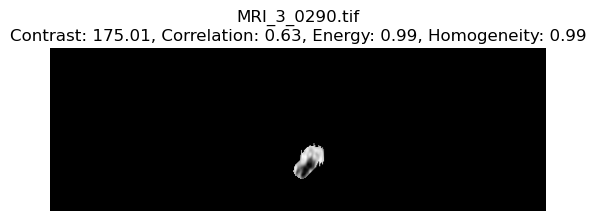

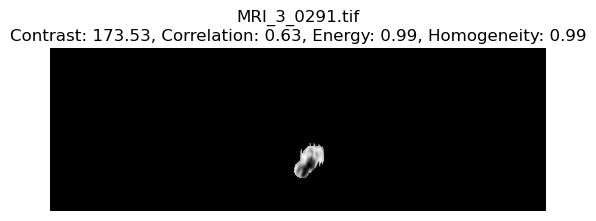

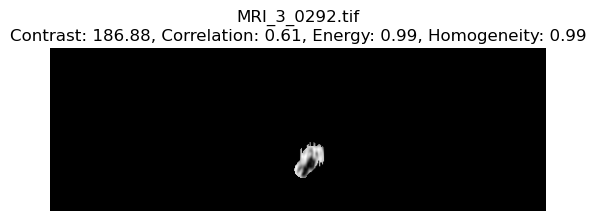

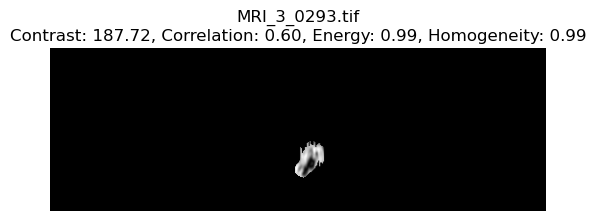

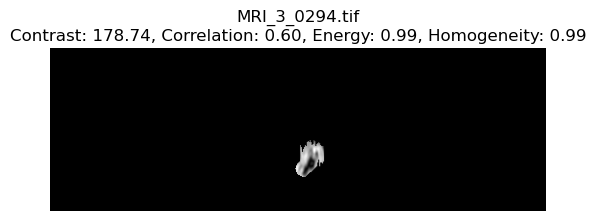

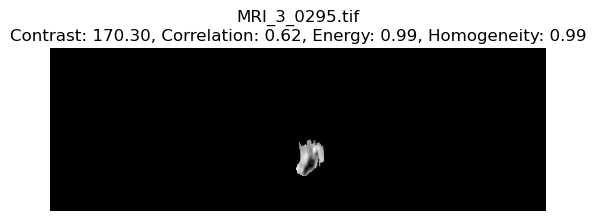

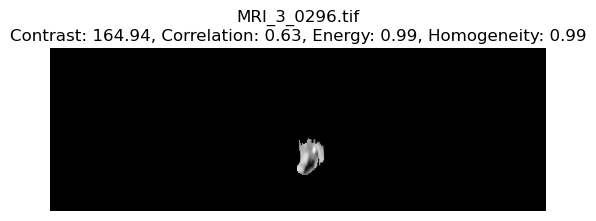

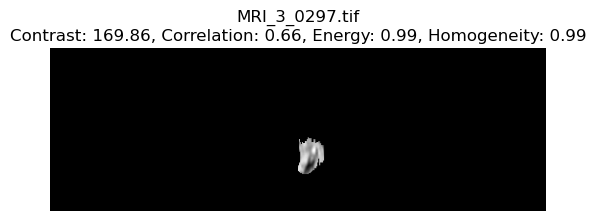

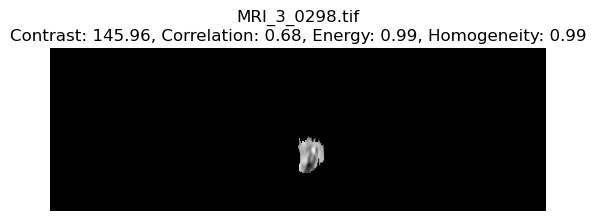

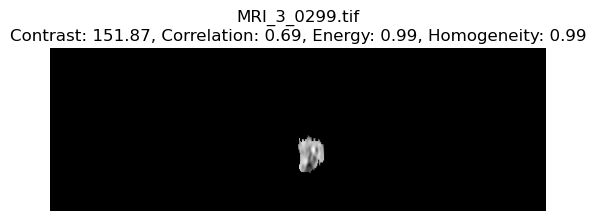

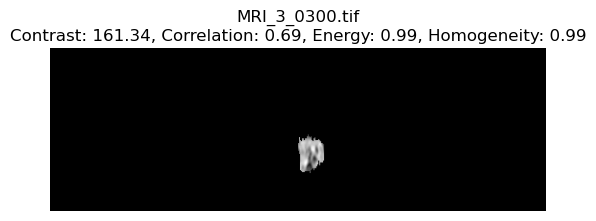

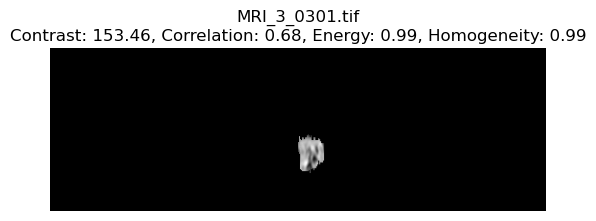

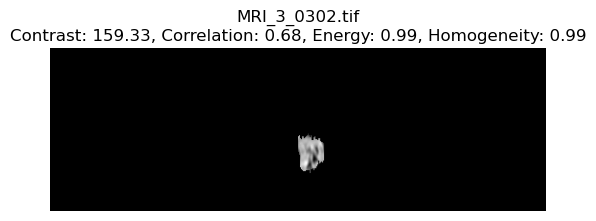

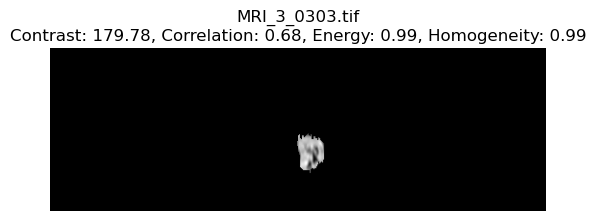

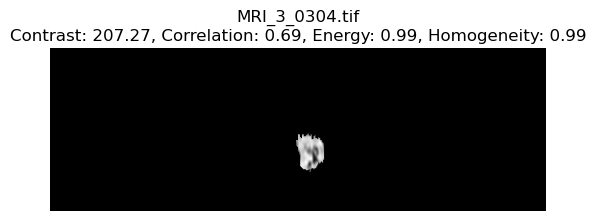

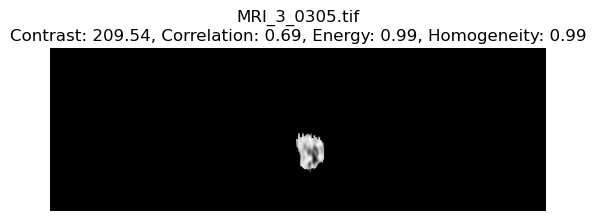

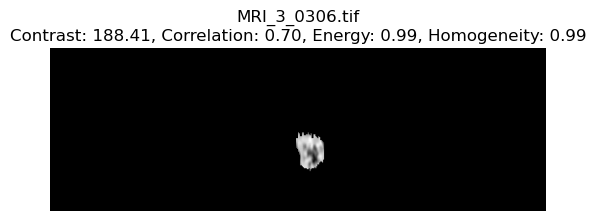

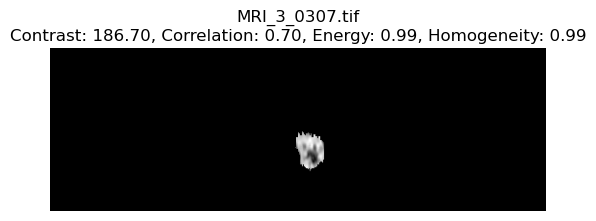

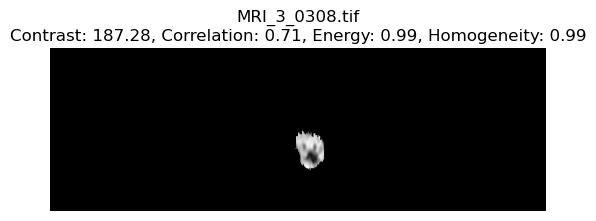

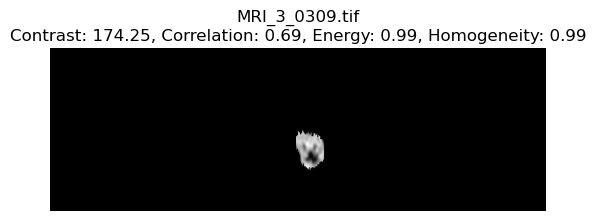

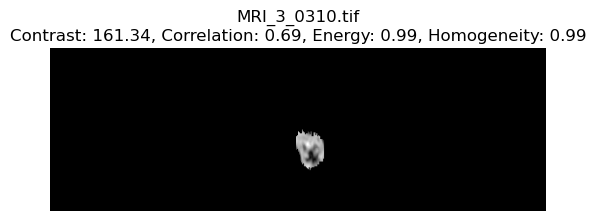

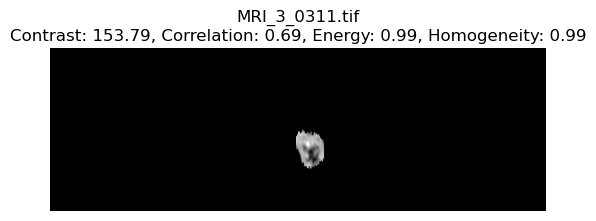

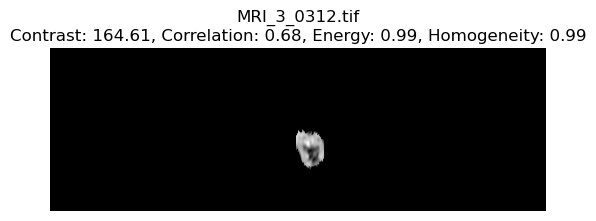

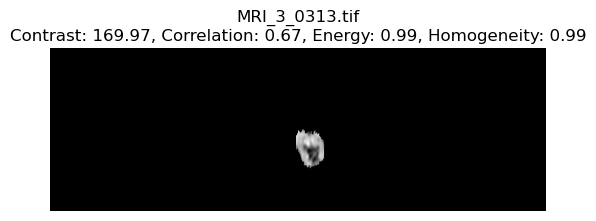

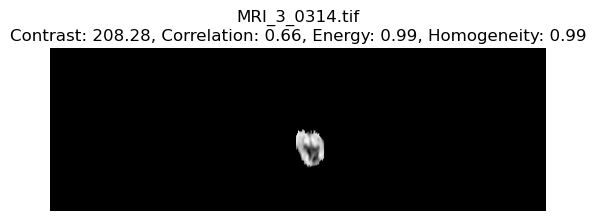

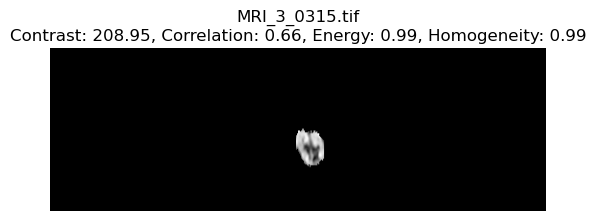

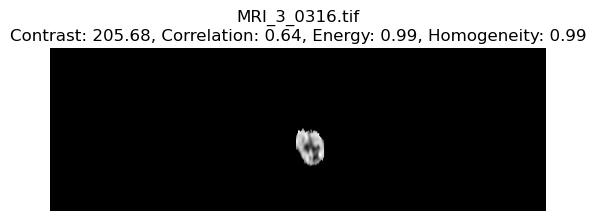

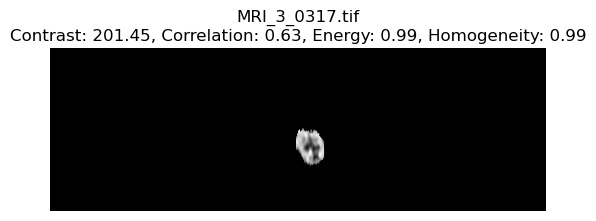

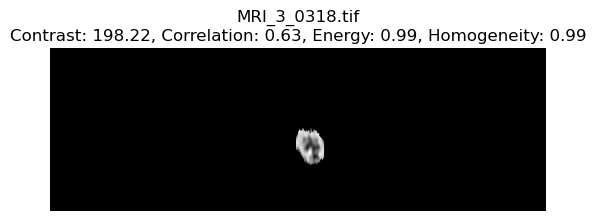

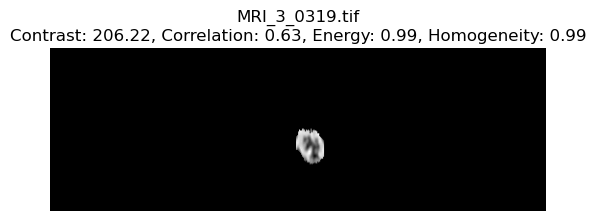

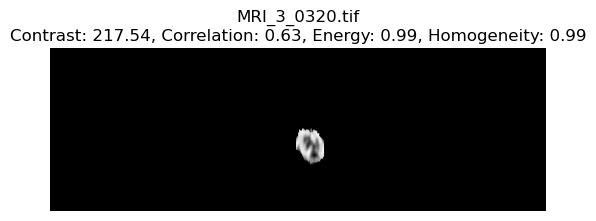

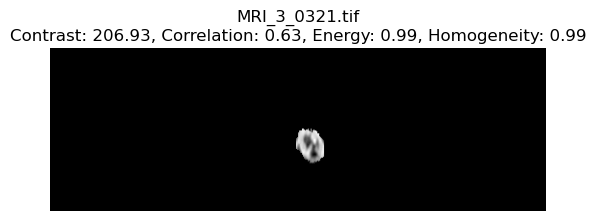

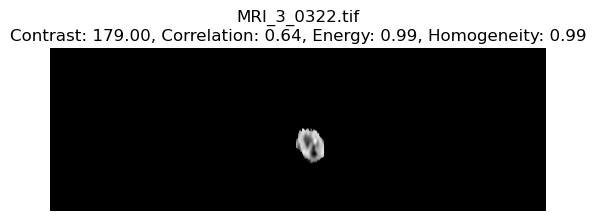

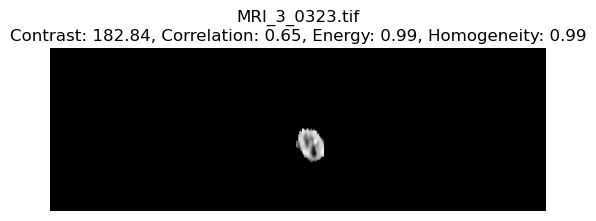

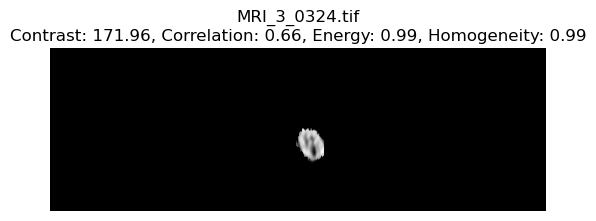

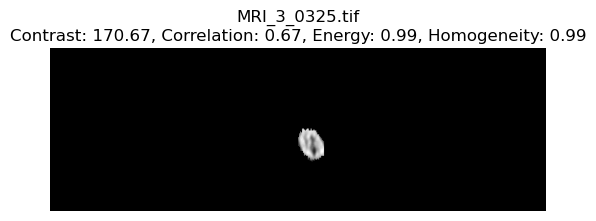

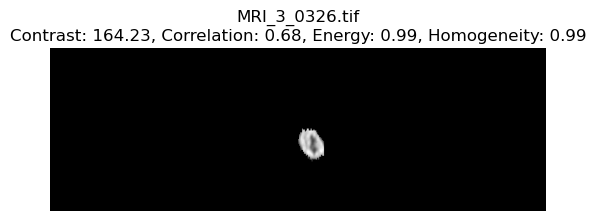

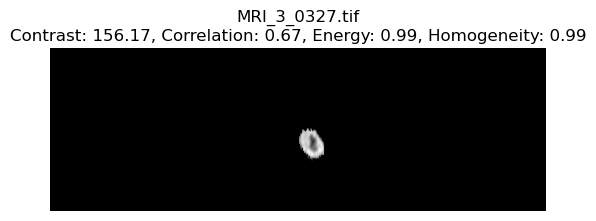

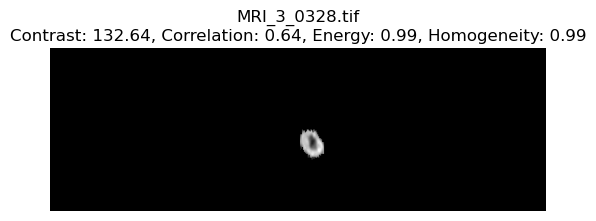

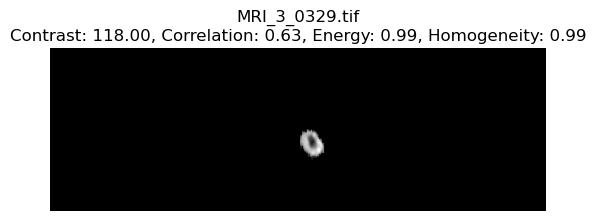

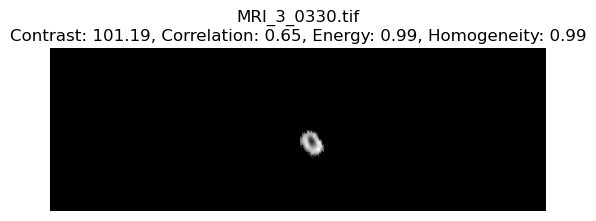

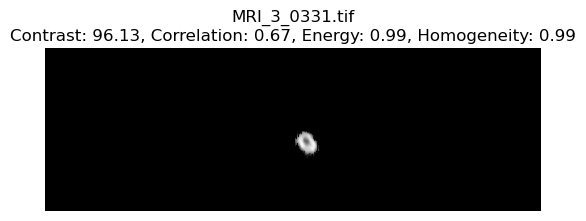

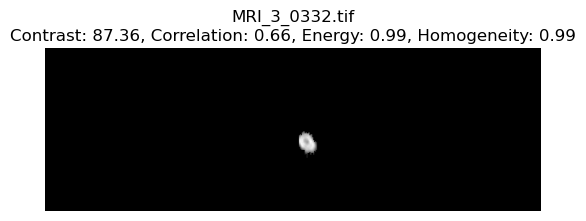

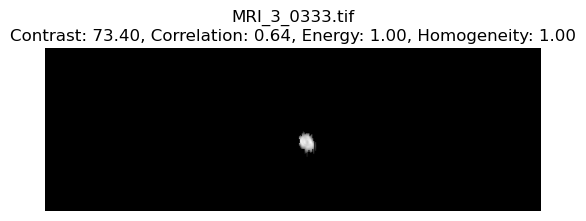

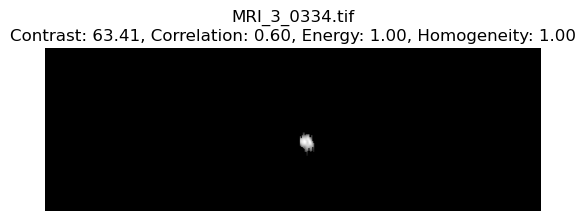

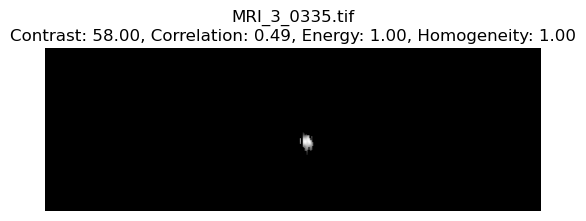

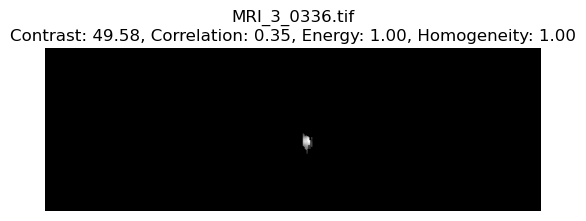

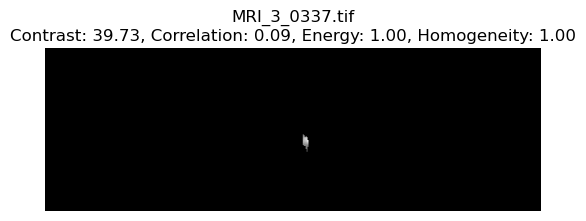

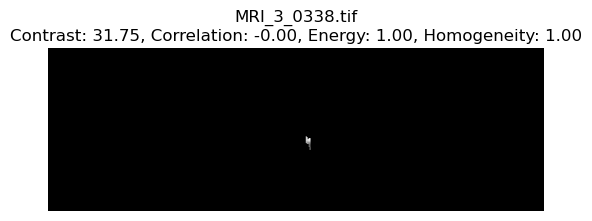

In [6]:
if __name__ == "__main__":
    image_directory = "path to images"  # Set your image directory here.
    converted_directory = os.path.join(image_directory, "MRI_3_converted")
    if not os.path.exists(converted_directory):
        os.makedirs(converted_directory)
    output_csv = os.path.join(converted_directory, "texture_analysis_results.csv")
    all_features = analyze_image_stack(image_directory, output_csv, converted_directory)
    show_images_with_analysis(converted_directory, all_features)